Эта ячейка импортирует необходимые библиотеки:
- random: для перемешивания данных
- defaultdict: для удобной группировки индексов по категориям
- Sampler: базовый класс для создания кастомных сэмплеров
- DataCollatorForTokenClassification: базовый класс для обработки данных токенизации
- pad_sequence: для выравнивания последовательностей разной длины
- torch: основная библиотека PyTorch
- F: функциональный API PyTorch
- DataLoader, Trainer, TrainingArguments: компоненты Hugging Face Transformers
- EarlyStoppingCallback: для ранней остановки обучения

Загрузка данных...
Загрузка модели...
Создание train датасета...
Найдено 21 классов
Классы: ['B-ADDRESS', 'B-CREDIT_CARD', 'B-EMAIL', 'B-FULL_NAME', 'B-IBAN', 'B-LICENSE_PLATE', 'B-PASSWORD', 'B-PHONE', 'B-SSN', 'B-USERNAME', 'I-ADDRESS', 'I-CREDIT_CARD', 'I-EMAIL', 'I-FULL_NAME', 'I-IBAN', 'I-LICENSE_PLATE', 'I-PASSWORD', 'I-PHONE', 'I-SSN', 'I-USERNAME', 'O']
Создание модели...


Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at iiiorg/piiranha-v1-detect-personal-information and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([18]) in the checkpoint and torch.Size([21]) in the model instantiated
- classifier.weight: found shape torch.Size([18, 768]) in the checkpoint and torch.Size([21, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-12-3388372181.py:294: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Создание тренера...
Начало обучения...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.024600,1.526640,0.620400,0.420791,0.620400,0.499571
2,1.352800,1.520251,0.621725,0.437679,0.621725,0.499509
3,1.218000,1.424373,0.641902,0.511679,0.641902,0.542936
4,1.106300,1.362772,0.637151,0.542389,0.637151,0.547158
5,1.050100,1.360927,0.631751,0.506001,0.631751,0.546487


Сохранение модели...
Результаты обучения:
Training Loss: 1.3504

--- Построение графиков обучения ---


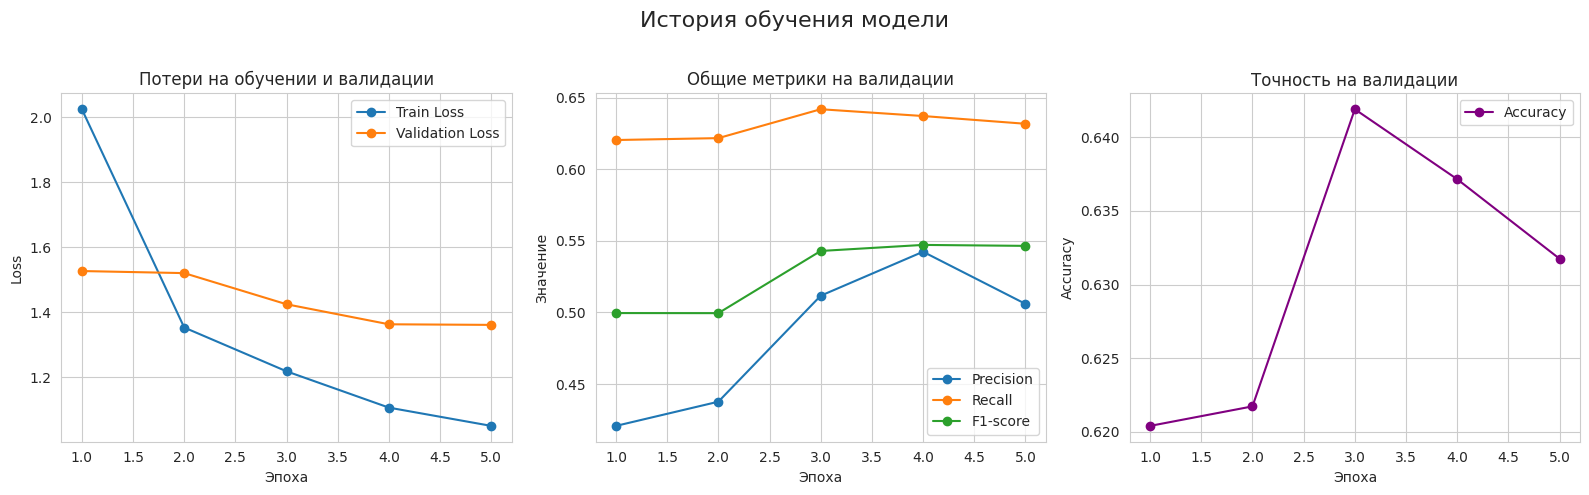

Оценка на тестовой выборке...


Результаты оценки:
eval_loss: 1.3628
eval_accuracy: 0.6372
eval_precision: 0.5424
eval_recall: 0.6372
eval_f1: 0.5472
eval_runtime: 3.4251
eval_samples_per_second: 110.9470
eval_steps_per_second: 7.0070
epoch: 5.0000
Обучение завершено!


In [12]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer
from torch.nn import CrossEntropyLoss
from torch.autograd import grad
import numpy as np
from collections import defaultdict
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
import gc
import matplotlib.pyplot as plt
import seaborn as sns

# Кастомный датасет для работы с нашими данными
class PersonalDataDataset(Dataset):
    """
    Датасет для задачи классификации персональных данных
    """
    def __init__(self, dataframe, tokenizer, max_length=256, split='train', label_to_id=None):
        # Фильтруем данные по split
        self.df = dataframe[dataframe['split'] == split].reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split

        # Создаем маппинг тегов в индексы
        if split == 'train' and label_to_id is None:
            # Для train создаем новый маппинг
            all_labels = set()
            for idx, row in self.df.iterrows():
                labels_list = row['mbert_token_classes'].split()
                all_labels.update(labels_list)

            # Создаем словари для преобразования тегов в индексы
            self.label_to_id = {label: i for i, label in enumerate(sorted(all_labels))}
            self.id_to_label = {i: label for label, i in self.label_to_id.items()}
            self.num_labels = len(self.label_to_id)
        else:
            # Для test используем переданный маппинг
            self.label_to_id = label_to_id
            if label_to_id is not None:
                self.id_to_label = {i: label for label, i in label_to_id.items()}
                self.num_labels = len(label_to_id)
            else:
                self.id_to_label = None
                self.num_labels = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Возвращает токенизированный текст и соответствующие метки
        """
        row = self.df.iloc[idx]

        # Получаем токены и метки
        try:
            # Пытаемся использовать eval для списков
            tokens = eval(row['mbert_tokens'])
        except:
            # Если eval не работает, парсим строку вручную
            tokens_str = row['mbert_tokens'].strip()
            if tokens_str.startswith('[') and tokens_str.endswith(']'):
                # Убираем скобки и разбиваем по запятым
                tokens_content = tokens_str[1:-1]
                # Разбиваем по запятым и очищаем
                tokens = []
                for token in tokens_content.split(','):
                    clean_token = token.strip().strip("'\"")
                    if clean_token:  # Проверяем, что токен не пустой
                        tokens.append(clean_token)
            else:
                # Просто разбиваем по пробелам
                tokens = row['mbert_tokens'].split()

        labels = row['mbert_token_classes'].split()  # Разделяем строку по пробелам

        # Ограничиваем длину
        if len(tokens) > self.max_length:
            tokens = tokens[:self.max_length]
            labels = labels[:self.max_length]

        # Токенизируем
        encoded = self.tokenizer(
            tokens,
            is_split_into_words=True,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Подготавливаем метки
        word_ids = encoded.word_ids()
        aligned_labels = []
        previous_word_idx = None
        label_all_tokens = True

        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)
            elif word_idx != previous_word_idx:
                if self.split == 'train':
                    aligned_labels.append(self.label_to_id[labels[word_idx]])
                else:
                    # Для test преобразуем метки в индексы если есть маппинг
                    if self.label_to_id is not None and labels[word_idx] in self.label_to_id:
                        aligned_labels.append(self.label_to_id[labels[word_idx]])
                    else:
                        # Если метки нет в маппинге, ставим -100 (игнорируем)
                        aligned_labels.append(-100)
            else:
                if self.split == 'train':
                    aligned_labels.append(self.label_to_id[labels[word_idx]] if label_all_tokens else -100)
                else:
                    # Для test
                    if self.label_to_id is not None and labels[word_idx] in self.label_to_id:
                        aligned_labels.append(self.label_to_id[labels[word_idx]] if label_all_tokens else -100)
                    else:
                        aligned_labels.append(-100)
            previous_word_idx = word_idx

        input_ids = encoded['input_ids'].squeeze(0)
        attention_mask = encoded['attention_mask'].squeeze(0)
        labels_tensor = torch.tensor(aligned_labels, dtype=torch.long)

        # Возвращаем только необходимые поля для HuggingFace Trainer
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels_tensor
        }

# Функция для вычисления метрик
def compute_metrics(eval_pred):
    """
    Вычисляет метрики для оценки модели
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=2)

    # Убираем игнорируемые токены (-100)
    true_predictions = []
    true_labels = []

    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            if labels[i][j] != -100:
                true_predictions.append(predictions[i][j])
                true_labels.append(labels[i][j])

    # Вычисляем метрики
    accuracy = accuracy_score(true_labels, true_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, true_predictions, average='weighted', zero_division=0)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Функция для построения графиков обучения
def plot_training_history(log_history):
    """
    Строит графики истории обучения
    """
    print("\n--- Построение графиков обучения ---")

    # Преобразуем историю в DataFrame
    logs = [log for log in log_history if 'loss' in log or 'eval_loss' in log]
    if not logs:
        print("Нет данных для построения графиков")
        return

    df = pd.DataFrame(logs)

    # Разделяем на train и eval
    train_df = df[df['loss'].notna()].reset_index(drop=True)
    eval_df = df[df['eval_loss'].notna()].reset_index(drop=True)

    if len(train_df) == 0 and len(eval_df) == 0:
        print("Нет данных train или eval для построения графиков")
        return

    # Настраиваем стиль графиков
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('История обучения модели', fontsize=16)

    # 1. График потерь (Loss)
    if len(train_df) > 0:
        axs[0].plot(train_df['epoch'], train_df['loss'], label='Train Loss', marker='o')
    if len(eval_df) > 0:
        axs[0].plot(eval_df['epoch'], eval_df['eval_loss'], label='Validation Loss', marker='o')
    axs[0].set_title('Потери на обучении и валидации')
    axs[0].set_xlabel('Эпоха')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # 2. График основных метрик (Precision, Recall, F1)
    if len(eval_df) > 0:
        if 'eval_precision' in eval_df.columns:
            axs[1].plot(eval_df['epoch'], eval_df['eval_precision'], label='Precision', marker='o')
        if 'eval_recall' in eval_df.columns:
            axs[1].plot(eval_df['epoch'], eval_df['eval_recall'], label='Recall', marker='o')
        if 'eval_f1' in eval_df.columns:
            axs[1].plot(eval_df['epoch'], eval_df['eval_f1'], label='F1-score', marker='o')
        axs[1].set_title('Общие метрики на валидации')
        axs[1].set_xlabel('Эпоха')
        axs[1].set_ylabel('Значение')
        axs[1].legend()

    # 3. График точности (Accuracy)
    if len(eval_df) > 0 and 'eval_accuracy' in eval_df.columns:
        axs[2].plot(eval_df['epoch'], eval_df['eval_accuracy'], label='Accuracy', marker='o', color='purple')
        axs[2].set_title('Точность на валидации')
        axs[2].set_xlabel('Эпоха')
        axs[2].set_ylabel('Accuracy')
        axs[2].legend()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Основная функция для запуска обучения
def main():
    # Загружаем данные
    print("Загрузка данных...")
    df = pd.read_csv('generated_logs_dataset_large.csv')

    # Загружаем модель и токенизатор
    print("Загрузка модели...")
    model_name = "iiiorg/piiranha-v1-detect-personal-information"
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Создаем train датасет для получения маппинга меток
    print("Создание train датасета...")
    train_dataset_initial = PersonalDataDataset(df, tokenizer, max_length=256, split='train')

    # Получаем маппинг меток
    label_to_id = train_dataset_initial.label_to_id
    num_labels = train_dataset_initial.num_labels
    print(f"Найдено {num_labels} классов")
    print("Классы:", list(label_to_id.keys()))

    # Создаем датасеты с правильным маппингом
    train_dataset = PersonalDataDataset(df, tokenizer, max_length=256, split='train', label_to_id=label_to_id)
    eval_dataset = PersonalDataDataset(df, tokenizer, max_length=256, split='test', label_to_id=label_to_id)

    # Создаем новую модель с правильным числом меток
    print("Создание модели...")
    model = AutoModelForTokenClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
        ignore_mismatched_sizes=True
    )

    # --- Настройки обучения оптимизированные для задачи ---
    training_args = TrainingArguments(
        output_dir='./trained_model',
        learning_rate=3e-5,  # Уменьшен для более стабильного обучения
        per_device_train_batch_size=16,  # Увеличен для лучшей эффективности
        per_device_eval_batch_size=16,
        num_train_epochs=3,  # Уменьшено для экономии времени
        weight_decay=0.01,

        # Стратегии логирования, оценки и сохранения
        logging_strategy="epoch",
        eval_strategy="epoch",
        save_strategy="epoch",

        # Ключевые параметры для управления памятью и выбором модели
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        greater_is_better=True,
        save_total_limit=1,

        # Оптимизации для экономии памяти
        fp16=torch.cuda.is_available(),  # Используем 16-bit точность если есть GPU
        optim="adamw_torch",

        # Отключаем внешние логгеры
        report_to="none",

        # Дополнительные оптимизации
        dataloader_pin_memory=True,
        remove_unused_columns=False,
        push_to_hub=False,
    )

    # Создаем тренер
    print("Создание тренера...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Запускаем обучение
    print("Начало обучения...")
    train_result = trainer.train()

    # Сохраняем модель
    print("Сохранение модели...")
    trainer.save_model()
    tokenizer.save_pretrained('./trained_model')

    # Выводим результаты обучения
    print("Результаты обучения:")
    print(f"Training Loss: {train_result.training_loss:.4f}")

    # Построение графиков обучения
    if hasattr(trainer, 'state') and hasattr(trainer.state, 'log_history'):
        plot_training_history(trainer.state.log_history)
    else:
        print("Нет истории обучения для построения графиков")

    # Оценка на тестовой выборке
    print("Оценка на тестовой выборке...")
    eval_results = trainer.evaluate()
    print("Результаты оценки:")
    for key, value in eval_results.items():
        print(f"{key}: {value:.4f}")

    print("Обучение завершено!")

    return trainer, eval_results

if __name__ == "__main__":
    trainer, results = main()

      
        Кастомный DataCollator наследуется от стандартного DataCollatorForTokenClassification
        и добавляет передачу категориальных меток в батч
        
        Параметры:
        - tokenizer: токенизатор для обработки текста
        - category_key: ключ для доступа к категориальным меткам в данных (по умолчанию "category")
        - **kwargs: дополнительные аргументы для родительского класса
      

        
        Кастомный сэмплер, который группирует данные по категориям в батче
        Гарантирует равномерное представительство всех категорий в каждом батче
    

# Ячейка 4: Кастомный Trainer с модифицированной функцией потерь

# Ячейка 5: Настройка и создание компонентов обучения